# Machine Learning Engineer Nanodegree 

## Capstone Project: Building a Handwritten Digit Recognizer

## Introduction
In this project, we are going to build a Deep Neural Network(DNN) that can recognize the digit handwritten in an image. The DNN is trained over MNIST dataset containing handwritten digits and their respective numerical digit. There are many architecture in DNN. The architecture we are going to use in this project is Residual Neural Network (ResNet).

## Requirements
 - Python 2.7
 - Anaconda2
 - Keras
 - Tensorflow or Theano
 - resnet - https://github.com/codekansas/keras-resnet/blob/master/resnet.py
 - opencv
 - (Optional) A GPU with Cuda support is highly recommended. Install graphics drivers, cuda toolkit, cudnn, tensorflow-gpu version

## Data Exploration

Run the below code to import the required python libraries and initialize variables

In [171]:
from __future__ import print_function
from numpy import random
from keras.datasets import mnist # helps in loading the MNIST dataset
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from keras.models import load_model
from resnet import Residual
import pygame.camera
from keras.utils.np_utils import probas_to_classes
import matplotlib.pyplot as plt
import pygame.camera, cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time
import cv2
import numpy as np
from scipy import ndimage
#to plot inside the notebook itself
%matplotlib inline 

# to be able to reproduce the same randomness
random.seed(42)  

# No of rows and columns in the image
img_rows = 28
img_cols = 28

#No of output classes (0-9)
nb_classes = 10

### Load the Dataset
Keras provides api to download and load the mnist dataset in a single line. Run the below line to download and load the dataset as training and testing set. 

Training set has 60000 samples.
Testing set has 10000 samples.


Row pixels in each image : 28.
Column pixels in each image : 28.


Successfully Downloaded and Loaded the dataset


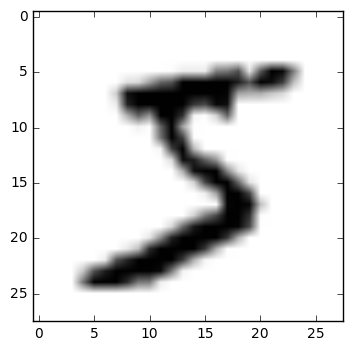

In [172]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Show the handwritten image
plt.imshow(X_train[0], cmap=cm.binary) 
# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))
print("\n")
# Show the number of rows and columns 
print("Row pixels in each image : {}.".format(X_train.shape[1]))
print("Column pixels in each image : {}.".format(X_train.shape[2]))
print("\n")
print("Successfully Downloaded and Loaded the dataset")

### Preprocess the Data

Keras can use either tensorflow or theano. While they both represent image in different format. Theano uses the format (no. of color channels, no. of rows, no. of cols) and tensorflow uses (no. of rows, no. of cols, no. of color channels). Thus a wrapper is needed when switching backends. Run the below code to ensure that the image is in the correct ordering for the respective background. 

In [173]:
if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
print("The data is reshaped to the respective format!" , input_shape)
print(y_train)

The data is reshaped to the respective format! (28, 28, 1)
[5 0 4 ..., 5 6 8]


The MNIST dataset contains grayscale images where the color channel value varies from 0 to 255. In order to reduce the computational load and training difficulty, we will map the values from 0 - 255 to 0 - 1 by dividing each pixel values by 255. Run the below code to do this.

In [174]:
X_train = X_train.astype('float32') #converted to float so that it can hold floating values between 0-1
X_test = X_test.astype('float32') #converted to float so that it can hold floating values between 0-1
X_train /= 255
X_test /= 255

The target labels y_train,y_test are in the form of numerical integers(0-9), we need to convert them to binary form in order for the neural network to perform mapping from input to output correctly and efficiently. Run the below code to do this.

In [175]:
print("In integer form : ", y_train,y_test)

Y_train = np_utils.to_categorical(y_train, nb_classes) #converted to their binary forms
Y_test = np_utils.to_categorical(y_test, nb_classes) #converted to their binary forms

print("In Binary form : ", Y_train,Y_test)

In integer form :  [5 0 4 ..., 5 6 8] [7 2 1 ..., 4 5 6]
In Binary form :  [[ 0.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]] [[ 0.  0.  0. ...,  1.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


## Implementing the Deep Residual Neural Network (ResNet)

### Build the Model
Run the code below to build the Deep Residual Neural Network

In [176]:
pool_size = (2, 2)
kernel_size = (3, 3)

input_var = Input(shape=input_shape)
conv1 = Convolution2D(64, kernel_size[0], kernel_size[1], border_mode='same', activation='relu')(input_var)
conv2 = Convolution2D(32, kernel_size[0], kernel_size[1], border_mode='same', activation='relu')(conv1)
conv3 = Convolution2D(8, kernel_size[0], kernel_size[1], border_mode='same', activation='relu')(conv2)
resnet = conv3
for _ in range(5):
    resnet = Residual(Convolution2D(8, kernel_size[0], kernel_size[1], border_mode='same'))(resnet)
    resnet = Activation('relu')(resnet)
mxpool = MaxPooling2D(pool_size=pool_size)(resnet)
flat = Flatten()(mxpool)
dropout = Dropout(0.5)(flat)
output = Dense(nb_classes, activation='softmax')(dropout)

model = Model(input=[input_var], output=[output])
print("Successfully built the ResNet!")

Successfully built the ResNet!


### Compile the Model
The model is compiled with 'categorical_crossentropy' as loss funtion, 'adadelta' as optimizer and 'accuracy' as metrics.

In [177]:
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])
print("Model Compilation completed!")

Model Compilation completed!


### Train the ResNet Model
Now let's the train the ResNet Model built above with mnist training dataset(X_train,Y_train). 

In [ ]:
batch_size = 1000 
nb_epoch=10 

start = time.time()
model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
          verbose=1, validation_data=(X_test, Y_test))
done = time.time()

elapsed = (done - start)/60

print("Model trained Successfully : Took - {} mins!".format(elapsed))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 126s - loss: 1.0853 - acc: 0.6318 - val_loss: 0.3133 - val_acc: 0.9114
Epoch 2/10
60000/60000 [==============================] - 125s - loss: 0.3544 - acc: 0.8912 - val_loss: 0.1789 - val_acc: 0.9483
Epoch 3/10
41000/60000 [===================>..........] - ETA: 37s - loss: 0.2517 - acc: 0.9244

In the neural network terminology:
- **one epoch** = one forward pass and one backward pass of all the training examples
- **batch size** = the number of training examples in one forward/backward pass. The higher the batch size, the more memory space you'll need.
- **number of iterations** = number of passes, each pass using [batch size] number of examples. To be clear, one pass = one forward pass + one backward pass (we do not count the forward pass and backward pass as two different passes).
- **Example**: if you have 1000 training examples, and your batch size is 500, then it will take 2 iterations to complete 1 epoch.

Reference : https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network/164875#164875

### Evaluate the ResNet Model
Now let's the test the ResNet Model built above with mnist test dataset(X_test,Y_test). 

In [25]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test Loss Value:', score[0])
print('Test Accuracy Value:', score[1])

Test Loss Value: 0.330277789998
Test Accuracy Value: 0.9112


## Test the Model with Real Data
Lets capture an image and convert it to the required format and then predict what digit is written in it. Make sure to have an internal webcam or usb webcam.

### Capture an Image from Camera
Using pygame library, let's capture an image which has a digit. Make sure to have the digit written in black color in a white background similiar to the mnist dataset. Also make sure to cover the whole webcam with the digit.

**Hint** If lazy to write a digit in a white paper, you can google an image of the number in mobile and show it in front of the webcam. 

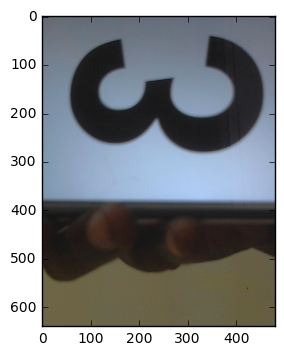

In [166]:
# Initialize the camera library
pygame.camera.init()

# Create the camera object
cam = pygame.camera.Camera(pygame.camera.list_cameras()[0])

# Access the camera
cam.start()

# Get the current image and store
img = cam.get_image()

# Stop the camera object and release
cam.stop()

# Exit the pygame camera library
pygame.camera.quit()

# Display the image captured
plt.imshow(pygame.surfarray.array3d(img))

### Preprocess the Captured Image
Using numpy, scipy, opencv let's preprocess the image into the format required by the model to predict

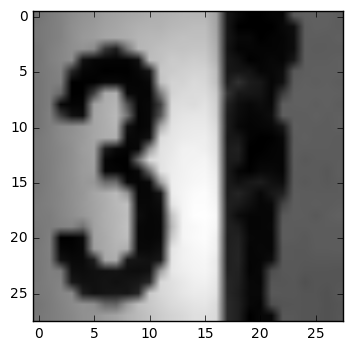

In [167]:
# Convert the image to numpy array
imgdata = np.asarray(pygame.surfarray.array3d(img))

# Convert the color image to rgb
gray = cv2.cvtColor(imgdata,cv2.COLOR_BGR2GRAY)

# Convert the grayscale image to numpy array
np_gray = np.asarray(gray)

# Rotate the image 90 degree in the clockwise direction(since pygame images have rows and cols interchanged)
rotated = ndimage.rotate(np_gray, -90)

# Flip the image to cancel the mirror effect caused by the camera
flip_img=cv2.flip(rotated,1)

# The grayscale image has black and white color interchanged, to invert it.
invert_img = (255-flip_img)

# Resize the image to 28,28 pixels as per the mnist dataset format
resized = cv2.resize(invert_img, (28, 28))

# Display the image
plt.imshow(resized, cmap=cm.binary)

# Convert the image format from (28,28) to (1,28,28,1) in order for the model to recognize
resized.shape+=1,
X_pred=np.array([resized])

### Predict the digit in the Image
Let's predict the number in the image using the trained model

In [169]:
# Predict the output
proba = model.predict(X_pred)

# Convert the predicted output to respective integer number
print(probas_to_classes(proba))

[3]


## Conclusion
Thus we have successfully implemented a Deep Residual Neural Network(ResNet) that can be trained over the MNIST dataset and can be used in real time to predict the handwritten digit directly from a webcam. The ResNet Model built have an Accuracy score of 0.9889